In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *

In [3]:
work_dir = Path('/kaggle/working/')
path = Path('../input')

In [4]:
train = 'train_images/train_images'
test =  path/'leaderboard_test_data/leaderboard_test_data'
holdout = path/'leaderboard_holdout_data/leaderboard_holdout_data'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [5]:
df = pd.read_csv(labels)
df_sample = pd.read_csv(sample_sub)

In [6]:
df.head(10)

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000
5,img_000092017.jpg,0,1.0000
6,img_000102017.jpg,0,1.0000
7,img_000112017.jpg,0,0.8352
8,img_000132017.jpg,0,1.0000
9,img_000142017.jpg,0,1.0000


In [7]:
df.describe()

,has_oilpalm,score
count,15244.000000,15244.000000
mean,0.061795,0.955769
std,0.240790,0.109367
min,0.000000,0.388700
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [8]:
(df.has_oilpalm==1).sum()

942

In [9]:
src = (ImageItemList.from_df(df, path, folder=train)
       .random_split_by_pct(0.2, seed=2019)
      .label_from_df('has_oilpalm'))

In [10]:
y_valid = src.valid.y.items; y_valid.sum()

201

## Add test set
We have to combine test and holdout for the submission

In [11]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]
src.add_test(test_names+holdout_names);

Useful to refactor this for late use

In [12]:
def get_data(size=128, bs=64):
    return (src.transform(get_transforms(flip_vert=True), size=size)
                   .databunch(bs=bs)
                   .normalize(imagenet_stats))

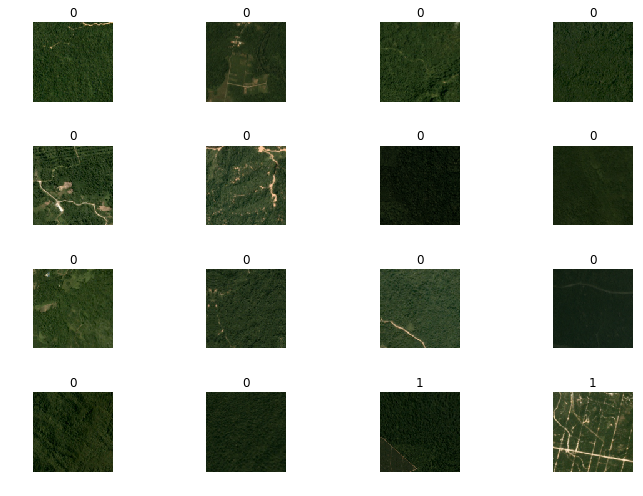

In [13]:
data = get_data()
data.show_batch(4, figsize=(10,7))

In [14]:
#This was working perfectly some minutes ago!
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1])) # use as metric

learn = create_cnn(data, models.resnet50, 
                   metrics=[accuracy], 
                   model_dir='/kaggle/working/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 83786797.01it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


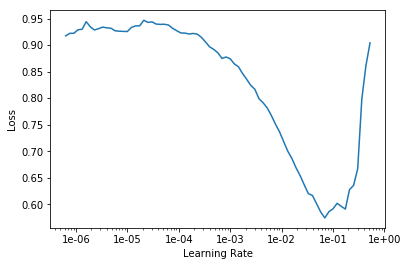

In [15]:
learn.lr_find(); learn.recorder.plot()

In [16]:
lr = 1e-3
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,accuracy
1,0.336694,0.103355,0.984580
2,0.069389,0.057802,0.986220
3,0.049556,0.031037,0.990486
4,0.037619,0.030876,0.990486
5,0.029055,0.028786,0.990814
6,0.021344,0.027422,0.991470


In [17]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.047944,0.065683,0.981299
2,0.034249,0.044510,0.984252
3,0.023013,0.027079,0.989829


In [18]:
p,t = learn.get_preds()
auc_score(p,t)

tensor(0.9981)

## Bigger:

In [19]:
# learn.data = get_data(256, 16)
# learn.freeze()
# learn.fit_one_cycle(3, slice(lr/15, lr/5))

# p,t = learn.get_preds()
# auc_score(p,t)

## Sub file

In [20]:
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [21]:
p = to_np(p); p.shape

(6534, 2)

In [22]:
ids = np.array([f.name for f in test_names]+[f.name for f in holdout_names])

In [23]:
ids.shape

(6534,)

In [24]:
sub = pd.DataFrame(np.stack([ids, p[:,1]], axis=1), columns=df_sample.columns)

In [25]:
sub.to_csv(work_dir/'sub.csv', index=False)